##  Aspects of Electro-Acoustics

##  40-mm speaker in a 100cc enclosure + Passive Radiator.
### Simulations, validation with WinISD. 

Stephane Dedieu, March 2023


These programs were developped for clients in a consulting practice, back in 2006-2009. <br> 
Initially all codes were Matlab or open source Scilab scripts. <br>
We coded them "as is" in Python. 



### Stetron Speaker 40-mm 

<span style="color:#4169E1"> Old 4 Ohms 40 mm speaker by Stetron. <br>
Its Thiele-small parameters were measured.  <br>

| parameter| value| units |
| :--- |  :--- | :--- |
|f_0  | $$176.23$$ |   $$Hz$$ |
|Re  | $$3.48$$   |  $$ohms$$|  
|Sd  | $$10.7 \; 10^{-4}$$|  $$m^2$$ |
|Vas | $$22.\; 10^{-6}$$| $$m^3$$  |
|Mmd | $$6, 10^{-3}$$ | $$kg$$ |           
|Bl  | $$3.4$$ | $$T.m$$ |
|Levc| $$0.015$$  | $$mH$$|         
|Qms | $$3.5$$    |     |
|Qes | $$2$$      |     |
|Qts | $$1.273$$  |     |
| Rm | $$1.89$$  | $$ohms$$ |

<span style="color:#4169E1"> Passive T/S parameters are shown below. Passive Radiator mass was tuned, for a resonance frequency $f_{0pr}$ close to 65 Hz.  

|parameter| value        | units |
| ---     |  ---         | ---   |
| Vaspr   | $$40.10^{-6}$$ | $$m^3$$ |
| Sdpr    | $$22.10^{-4}$$ | $$m^2$$ |
| Mmdpr   | $$24.10^{-3}$$ | $$kg$$  |
| Qmspr   |    $$9$$       |         |

|<img src="D0040.jpg" width="200" height="200">     |  
| --- | 
| <center> 4 Ohms - 40-mm  Stetron speaker </center>    | 

<b> Validation </b>  <br>
    
<span style="color:#4169E1"> We validate our model with WinISD. <br>  WinISD by LinearTeam http://www.linearteam.org/ is an open source tool for simulating loudspeakers in various enclosures: closed, ported, passive radiator. Based on lumped parameters. <br>     
The Scilab/Matlab script was initially developped to design miniature speaker systems with passive radiators. WinISD is not well suited for miniature speakers and Thiele-Small parameters having very small values. Conversion are necessary and generally prone to errors.  <br>  
Overall, our model matches WinISD simulation pretty well except for the damping around the pasive radiator resonance. And at very low frequency the match is not perfect. <br>
Mismath maybe due to:   
- <span style="color:#4169E1">slow leak in the enclosure: "resitor" model (fluid viscosity).
- <span style="color:#4169E1">different model for acoustic impedance: added mass by the fluid (air), complex radiating impedance: resistor (loss). 

<span style="color:#4169E1"> In further works, we will analyse radiation impedance models and damping models, used by the team at LinearTeam compared with Leo Beranek's models.  
   
| <img src="Speaker_with_PassiveRadiator_Matlab_v2.png" width="400">     |   <img src="Speaker_with_PassiveRadiator_WinISD_v1.png" width="350"> |
| --- | ---  |
| <center> Our simulation (Matlab) </center>    | <center>Simulation with WinISD </center>     |    
    
      
    
    
<span style="color:#4169E1"> <b> References:</b> <br>
[1] Leo Beranek “Acoustics”, 1993 Edition

###  Speaker in a enclosure + Passive Radiator

<span style="color:#4169E1"> Impedance model of a speaker in an enclosure with a passive radiator.


| <img src="PassiveRadiatorBox.png" width="150">     |   <img src="EQCircuit_BassReflex.png" width="500"> |
| --- | ---  |
| <center>Speaker enclosure with passive radiator</center>| <center>Bass-reflex Equivalent Circuit </center>|

<span style="color:#4169E1"> The model of a speaker enclosure with a passive radiator is a variant of the ported enclosure shown above. The "port" equivalent RL circuit must be replaced with a RLC circuit, with:
    
- <span style="color:#4169E1">Rpr: passive radiator damping (+acoustic radiated impedance: loss)
- <span style="color:#4169E1">Lpr: mass of the passive radiator cone (+ mass added by air)
- <span style="color:#4169E1">Cpr: compliance of passive radiator suspension. 

### Python script

In [24]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [25]:
import scipy
from scipy import signal
from skimage import util
from scipy.signal import general_gaussian
from scipy.signal import savgol_filter
from scipy.fftpack import fft, fftshift
import cmath
import math

In [26]:
def parallel(z1,z2) :
    z = (z1*z2)/(z1+z2)
    return z

def series(z1,z2) :
    z = z1 + z2    
    return z

In [27]:
#------------------
#Acoustic constants
#------------------
ro = 1.21  # Air density (kg/m3) 
cel = 340  # Sound celerity m/s
afreq= np.arange(10, 10000, 1, dtype=int) # frequency range for simluation
w = (2*np.pi)*afreq     # circular frequency (rad/s)
k = w/cel               # wavenumber rad/m              

In [48]:
#=============================================================
#  Frequency response of a speaker  - in a baffle          
#                                   - in a sealed enclosure
#                                   - in a ported enclosure
# 
#  Reviewed Stephane - 11 Septembre 2007 
#  Reviewed Stephane - May 1st, 2009
#=============================================================
#
#============  Thiele Small Parameters (Electro-Mechanical Parameters) ==========================
#------------  Stetron 40-mm speaker  ---------
f0 = 176.23;   # 1st Resonance Frequency (Hz)
w0 = (2*np.pi)*f0;
Re = 3.48;    # Voice Coil DC resistance (Ohms)
Sd = 10.7e-04;         # Diaphragm Area (m2)
Vas = 22.00e-06;
# Equivalent volume (m3) - linked to suspension compliance
ksv = ((ro*(cel**2))*(Sd**2))/Vas;
# Suspension stiffness  (N/m)
#-----------------------------------------------
Mmd =  6e-03;
# Mass of speaker cone + voice coil  (kg) includes air added mass             
Bl = 3.4;
# Force factor Bl(Tesla.m) 
# B= Magnetic flux density in air gap, l= length of voice coil wire 
# force on voice coil= Bl*i     (i=current)
Levc = 0.015;
# Voice coil inductance (Added 14 sept)
#-----------------------------------------------                            
Qms = 3.5;
# Mechanical Q at f0
Qes = 2;
# Electrical Q at f0
Qts = 1.273;
# Total quality factor at f0:   Qts=Qms*Qes/(Qms+Qes) 
Rm = (((2*np.pi)*f0)*Mmd)/Qms

#Qms=(((2*np.pi)*f0)*Mmd)/Rm;
#Qes = 2*np.pi*f0*Re*Mmd/Bl**2;
#Qts=Qms*Qes/(Qms+Qes);
#
# Mechanical resistance from Qms definition: (Qms=2*np.pi*f0*Mmd/Rm) 
#====================
Ze = Re+(Levc*1j)*w;
# Voice coil Impedance (replaces Re) Added 14 Septembre 2007

In [29]:
#=================================================================================================
#              Sound Pressure radiated by the speaker in an infinite Baffle 
#              FOR VALIDATIONS PURPOSES ONLY (to be compared with TangBand measurement 1W/1meter)
#=================================================================================================
# 
rr =   1;                 # Computation at  1 meter
rrport=1;
Em =   2.0;              # Input voltage (V) ~ Sweep sine
Em =  np.sqrt(Re);       # Input voltage (V) for 1W input ~ Sweep sine
pbaffle = (((((Em*Bl)*ro)*Sd)/((((2*np.pi)*Re)*Mmd)*rr))*((w/w0) **2)) /(1+(1j *w) /(Qts*w0)-(w /w0) **2);
#--------------------------
#  volume velocity  q=Sd*ud
#--------------------------
ud = ((Em*Bl) /Ze) /((Bl**2) /Ze+(Mmd*1j) *w+ksv /(1j *w));
#
pdirect = (((((1j*ro) *w) *ud)*Sd) *np.exp(-(1j *k)*rr))/((2*np.pi)*rr);

In [45]:
#======================================================================
#           SPEAKER  Enclosure Parameters + Electrical Parameters          |
#======================================================================
Vbcc= 100;                        # Enclosure volume (cm3)
Vb=Vbcc*1e-06;
#-------------
kb = ((ro*(cel**2))*(Sd**2))/Vb;    # Enclosure "stiffness" N.m    
#-----------------------------
#Ma = Air Added Mass enclosure
#-----------------------------
a = np.sqrt(Sd/np.pi);   # diaphragm radius 
RAR2=(ro*cel*w**2)/(np.pi*(w**2*a**2 + 2*cel**2));  # dissipation
Rm =   Rm + RAR2*Sd**2
Ma1 = (((8*ro)*Sd)*a)/(3*np.pi);
M = Mmd+Ma1;
#M=Mmd;
#-----------------------------
# Speaker suspension Stiffness
#-----------------------------
Cas = Vas/(ro*(cel**2));
Cms = Cas/(Sd**2);
ks=1/Cms;
#
ksealed = ks+kb;
#==================================
# Speaker + Enclosure stiffness
#==================================
w0s = np.sqrt(ksealed/M);         # Speaker f0 in the sealed enclosure
f0s = w0s/(2*np.pi);
Qtsenc = np.sqrt(ksealed*M)/(Rm+(Bl**2)/Re);
Cmb=1/kb;
#======================================================
#                 PASSIVE RADIATOR CHARACTERISTICS
#======================================================
Sdpr = 22e-4      # Diaphragm Area (m2)
Vaspr =  40e-06   # Equivalent volume (m3) - linked to suspension compliance
ksvpr = ((ro*(cel**2))*(Sd**2))/Vaspr  # Suspension stiffness  (N/m)
CMpr=1/ksvpr   # Suspension compliance
#-----------------------------------------------
Mmdpr =4*6e-03         #   kg   Tuning the Passive Radiator Mass
apr = np.sqrt(Sdpr/np.pi)   # passive radiator radius 
Mapr = (((8*ro)*Sdpr)*apr)/(3*np.pi)
Mmdpr=Mmdpr+Mapr 
#-----------------------------------------------
f0pr=(1/(2*np.pi))*np.sqrt(ksvpr/Mmdpr)
#-----------------------------------------------                            
Qmspr =9
RAR2=(ro*cel*w**2)/(np.pi*(w**2*apr**2 + 2*cel**2))  # dissipation

Rmpr = (((2*np.pi)*f0pr)*Mmdpr)/Qmspr 

#Rmpr =   Rmpr + RAR2*Sdpr**2 

In [43]:
#=============  Sound Pressure radiaated by the speaker in an enclosurezspeaker=  M*(1j*w) +  (Rm+ Bl**2/Re)+ ( 1 /(Cms*(1j*w)));
#
pg=Em*Bl/(Sd*Re);          #  Newtons/m2

pg=2*pg;                   # "1jNF1jN1jTE BAFFLE": + 6dB

zel1=Levc*Sd**2/Bl**2;
zel2=Bl**2/(Re*Sd**2);

# zarport=(RAR2 + MAR2*(1j*w))*Sd**2;

zelec=parallel(zel1,zel2);
#
zspeaker=  M*(1j*w) + Rm + ( 1 /(Cms*(1j*w))) + zel2*Sd**2;
#
zcavity=( Rs   +  1  /(Cmb*(1j*w)));           #   Rs effect of a leak 1jn the cav1jty


# Pass1jve rad1jator 1jmpedance 
Zspr=Mmdpr*(1j*w) + Rmpr + ( 1 /(CMpr*(1j*w)));  
#--------------------------------

Z1=parallel(zcavity,Zspr);
#
Ztotal=zspeaker+Z1;
Zclosed=series(zspeaker,zcavity);  


Ud=pg/Ztotal;

Uclosed=pg/Zclosed;

Up1=Ud/(1+Zspr/zcavity);


pud=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Ud ; 
puclose=(ro*Sd**2/(4*np.pi*rr))*np.exp(-(1j *k)*rr  )*1j*w*Uclosed; 
pup1=(ro*Sd**2/(4*np.pi*rrport))*np.exp(-(1j *k)*rr  )*1j*w*Up1; 



puu=pud-pup1;  

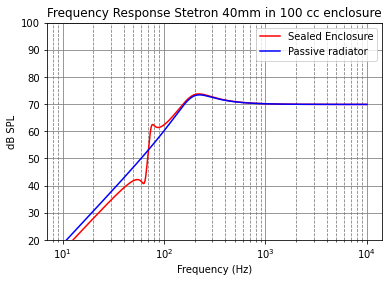

In [51]:
plt.semilogx(afreq,20*np.log10(abs(puu)/0.00002),'r')
plt.semilogx(afreq,20*np.log10(abs(puclose)/0.00002),'b')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')
plt.ylim(20,100);
plt.xlabel('Frequency (Hz)');
plt.ylabel('dB SPL');
plt.legend(['Sealed Enclosure', 'Passive radiator']);
plt.title('Frequency Response Stetron 40mm in '+str(Vbcc)+' cc enclosure');